In [1]:
%config InlineBackend.figure_format = 'retina'

In [259]:
from matplotlib.pyplot import *
import pandas as pd
import numpy as np

rc('font', size=8)

pd.set_option('display.max_columns', 500)

In [348]:
df = pd.read_csv('data/train.csv')

df = df[~((df['SalePrice'] < 300000) & (df['GrLivArea'] > 4000))].reset_index(drop=True)

## Exploration

<Axes: >

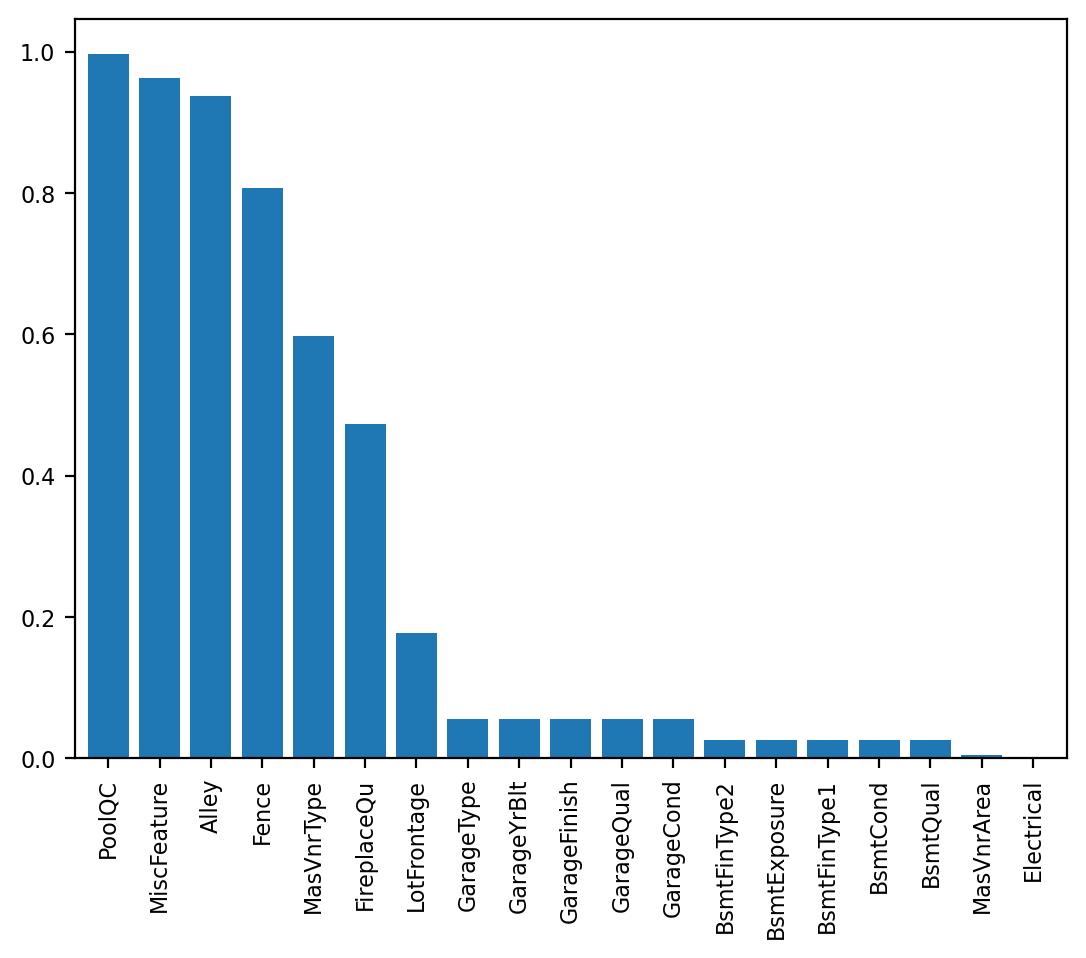

In [349]:
(df.isnull().sum()[lambda x: x > 0] / len(df)).sort_values(ascending=False).plot.bar(width=0.8)

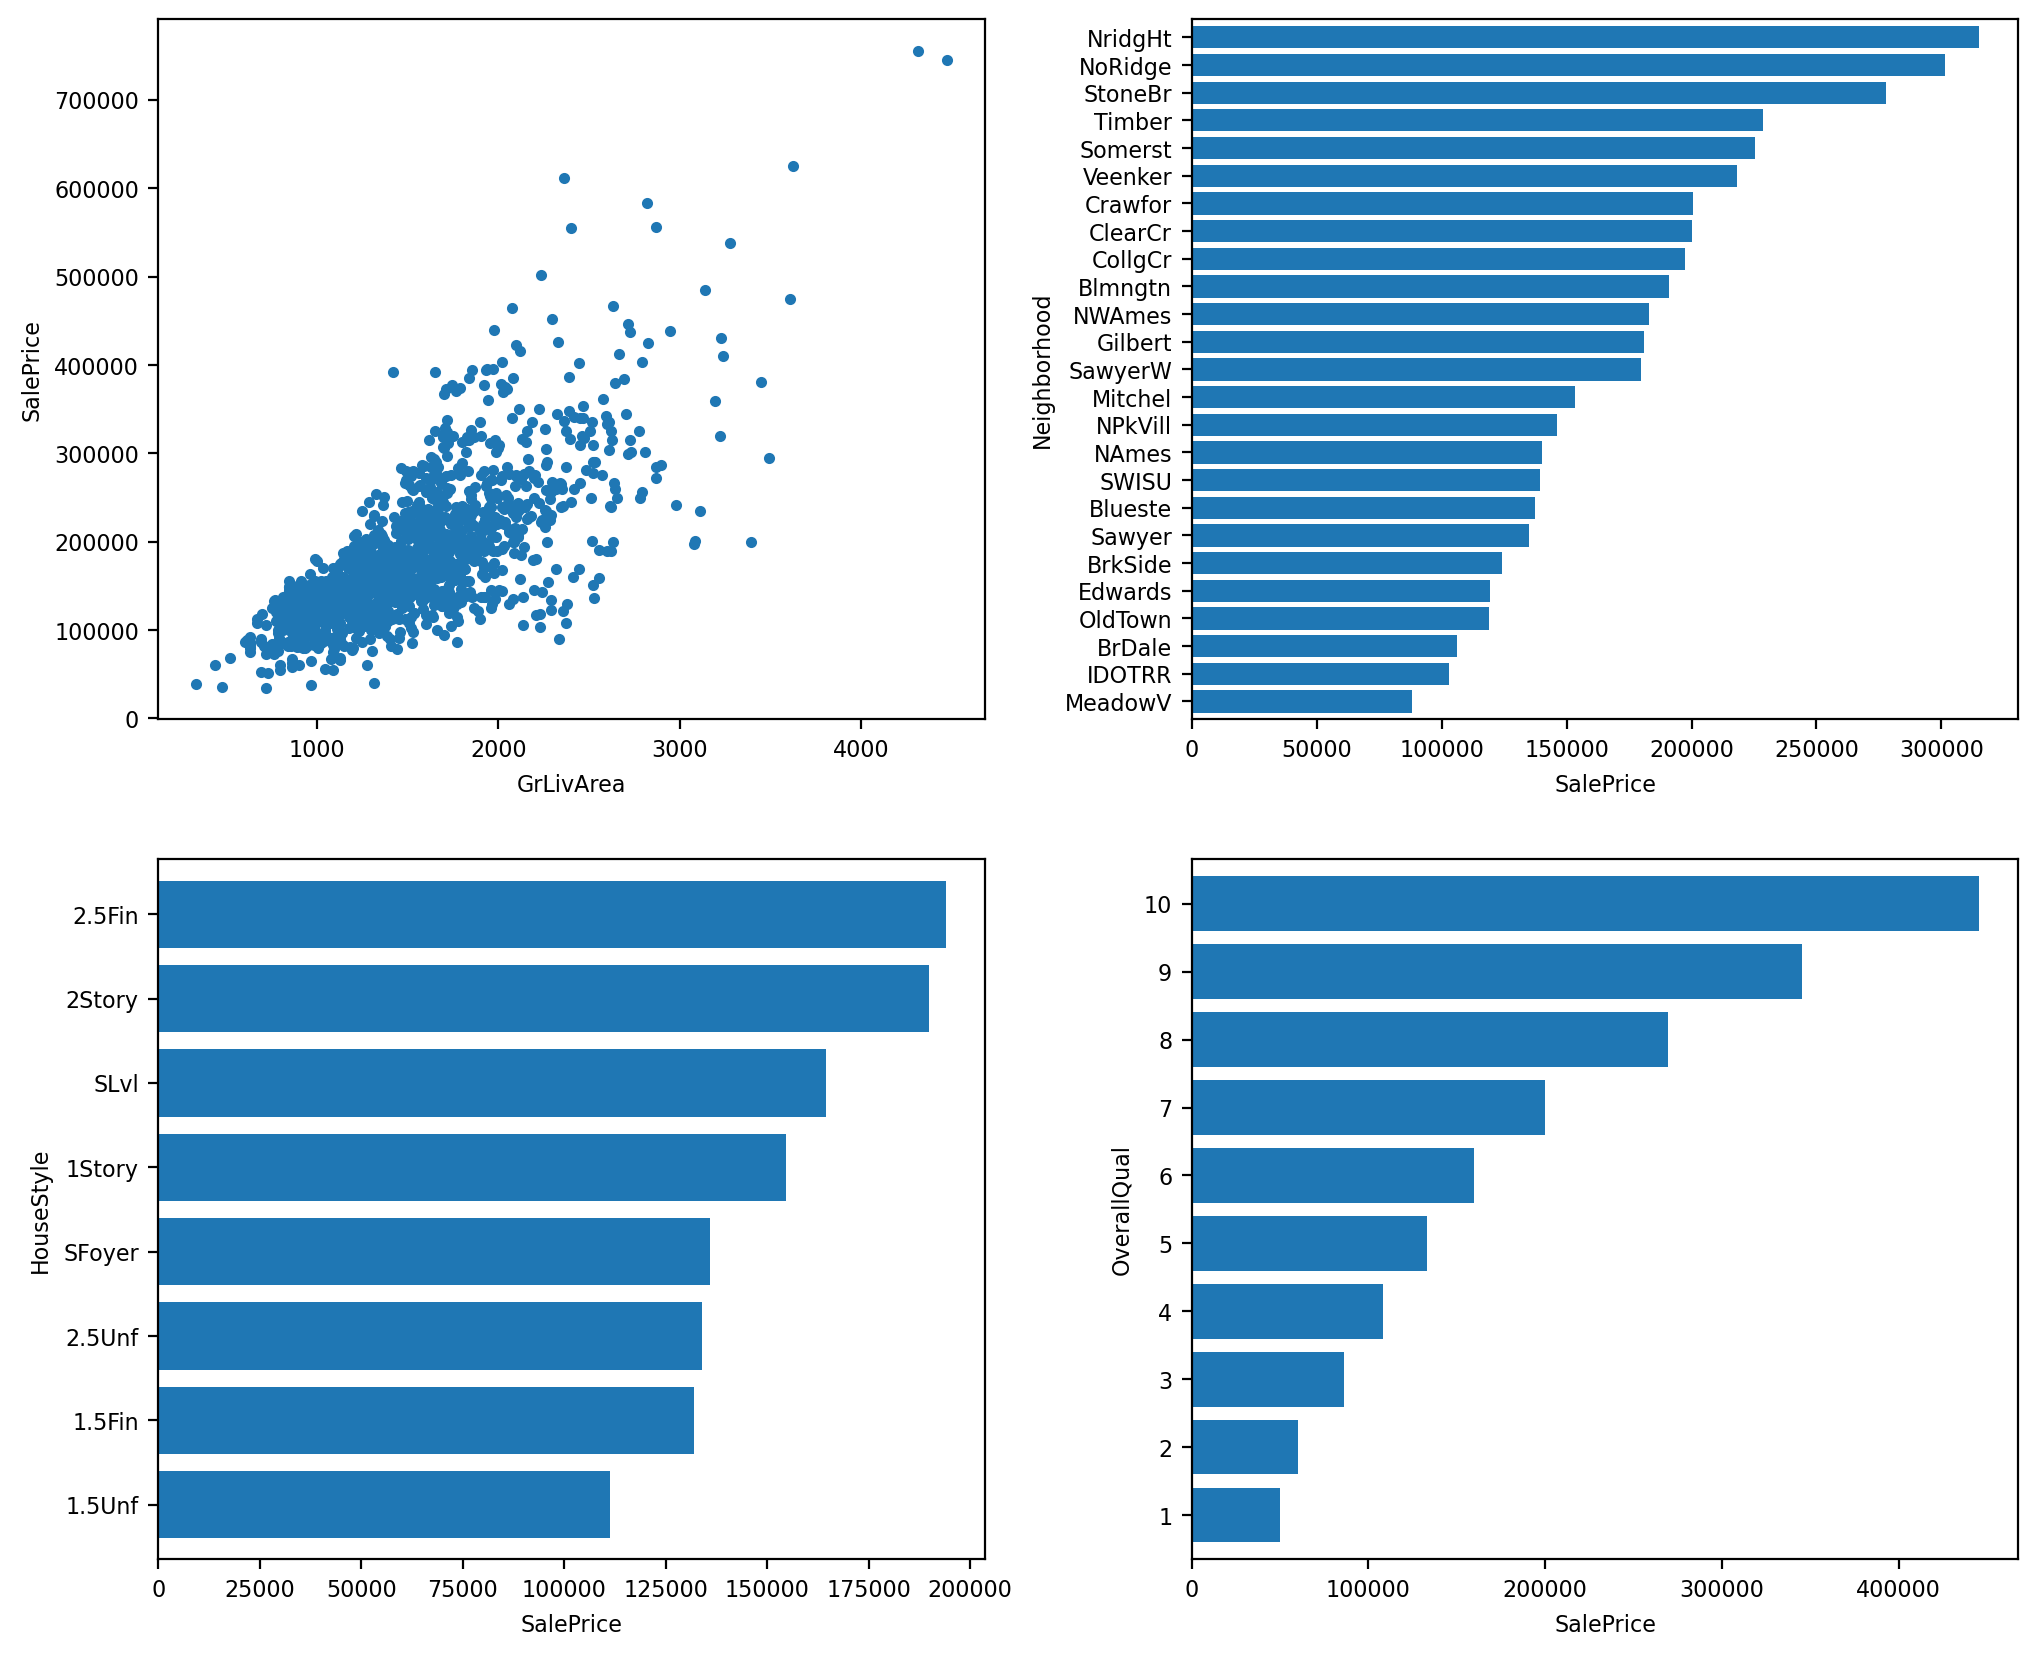

In [350]:
fig, axs = subplots(nrows=2, ncols=2, gridspec_kw={'wspace': 0.25, 'hspace': 0.2}, figsize=(12, 10))

df.plot(x='GrLivArea', y='SalePrice', style='.', legend=False, ax=axs[0, 0])
df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=True).plot.barh(width=0.8, ax=axs[0, 1])
df.groupby('HouseStyle')['SalePrice'].median().sort_values(ascending=True).plot.barh(width=0.8, ax=axs[1, 0])
df.groupby('OverallQual')['SalePrice'].median().sort_values(ascending=True).plot.barh(width=0.8, ax=axs[1, 1])

axs[0, 0].set_ylabel('SalePrice')
axs[0, 1].set_xlabel('SalePrice')
axs[1, 0].set_xlabel('SalePrice')
axs[1, 1].set_xlabel('SalePrice');

### Fill Missing Values

In [351]:
# PoolQC: categorical, fill None
# MiscFeature: categorical fill None
# Alley: categorical None
# Fence: categorical None
# MasVnrType: categorical None, nearly always null when area is 0
# FireplaceQu: ordinal None, always null when fireplaces is 0
# LotFrontage: continuous, df[df['LotShape'] == 'IR1']['LotFrontage'].median()
# Garage are null because there is no garage: GarageType	GarageYrBlt	GarageFinish	GarageCars	GarageArea	GarageQual	GarageCond
# BsmtFinType2 is null because there is no basement except for one case. In this case use Unf.
# MasVnrArea fill with 0
# Electrical fill with SBrkr

In [352]:
fill_values = {
    'PoolQC': 'Missing',
    'MiscFeature': 'Missing',
    'Alley': 'Missing',
    'Fence': 'Missing',
    'MasVnrType': 'Missing',
    'FireplaceQu': 'Missing',
    'LotFrontage': 74,
    'GarageType': 'Missing',
    'GarageYrBlt': 0,
    'GarageFinish': 'Missing',
    'GarageCars': 0,
    'GarageQual': 'Missing',
    'GarageCond': 'Missing',
    'BsmtFinType2': 'Missing',
    'BsmtExposure': 'Missing',
    'BsmtFinType1': 'Missing',
    'BsmtQual': 'Missing',
    'BsmtCond': 'Missing',
    'MasVnrArea': 0,
    'Electrical': 'SBrkr'
}

In [353]:
df = df.fillna(fill_values)

## Feature Engineering

In [354]:
df['TimeSinceBuild'] = df['YrSold'] - df['YearBuilt']
df['TimeSinceRemoAdd'] = df['YrSold'] - df['YearRemodAdd']
df['TimeDiffBuildRemoAdd'] = df['YearRemodAdd'] - df['YearBuilt']

df['TotalSF'] = df['TotalBsmtSF'] + df['GrLivArea']
df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] + df['FullBath'] + df['HalfBath']

## Separate the Features

In [355]:
continuous_features = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal'
]

In [356]:
discrete_features = [
    'YearBuilt',
    'YearRemodAdd',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'MoSold',
    'YrSold'
]

In [357]:
ordinal_features = [
    'OverallQual',
    'OverallCond',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond'
]

In [358]:
nominal_features = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'GarageFinish',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

In [359]:
numerical_features = continuous_features + discrete_features

categorical_features = nominal_features + ordinal_features

## Modeling

In [360]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from hyperopt import fmin, tpe, hp, space_eval
from hyperopt import Trials, STATUS_OK
from hyperopt.pyll import scope

In [371]:
x_tr, x_te, y_tr, y_te = train_test_split(df.drop(['Id', 'SalePrice'], axis=1), df['SalePrice'], test_size=0.2, random_state=0)

In [383]:
categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [384]:
search_space = {
    'max_iter': scope.int(hp.quniform('max_iter', 10, 500, q=1)),
    'learning_rate': 10**hp.uniform('learning_rate', -3, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, q=1)),
    'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 2, 200, q=1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 200, q=1)),
    'l2_regularization': 10**hp.uniform('l2_regularization', -3, 2),
    'max_bins': scope.int(hp.quniform('max_bins', 10, 255, q=1))
}

In [385]:
def objective(params):

    regressor = HistGradientBoostingRegressor(
        **params,
        loss='squared_error',
        early_stopping='auto',
        validation_fraction=0.2,
        random_state=0
    )

    transformed_regressor = TransformedTargetRegressor(
        func=np.log,
        inverse_func=np.exp,
        regressor=regressor
    )

    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', transformed_regressor)
        ]
    )

    scores = cross_validate(pipeline, x_tr, y_tr, cv=5, scoring=['neg_root_mean_squared_error'], n_jobs=-1)

    return {'model': pipeline, 'loss': -scores['test_neg_root_mean_squared_error'].mean(), 'status': STATUS_OK}

In [386]:
trials = Trials()

argmin = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|█████████| 50/50 [03:05<00:00,  3.71s/trial, best loss: 26081.979790882506]


In [393]:
model = trials.best_trial['result']['model']

model.fit(x_tr, y_tr);

In [388]:
prediction = model.predict(x_te)

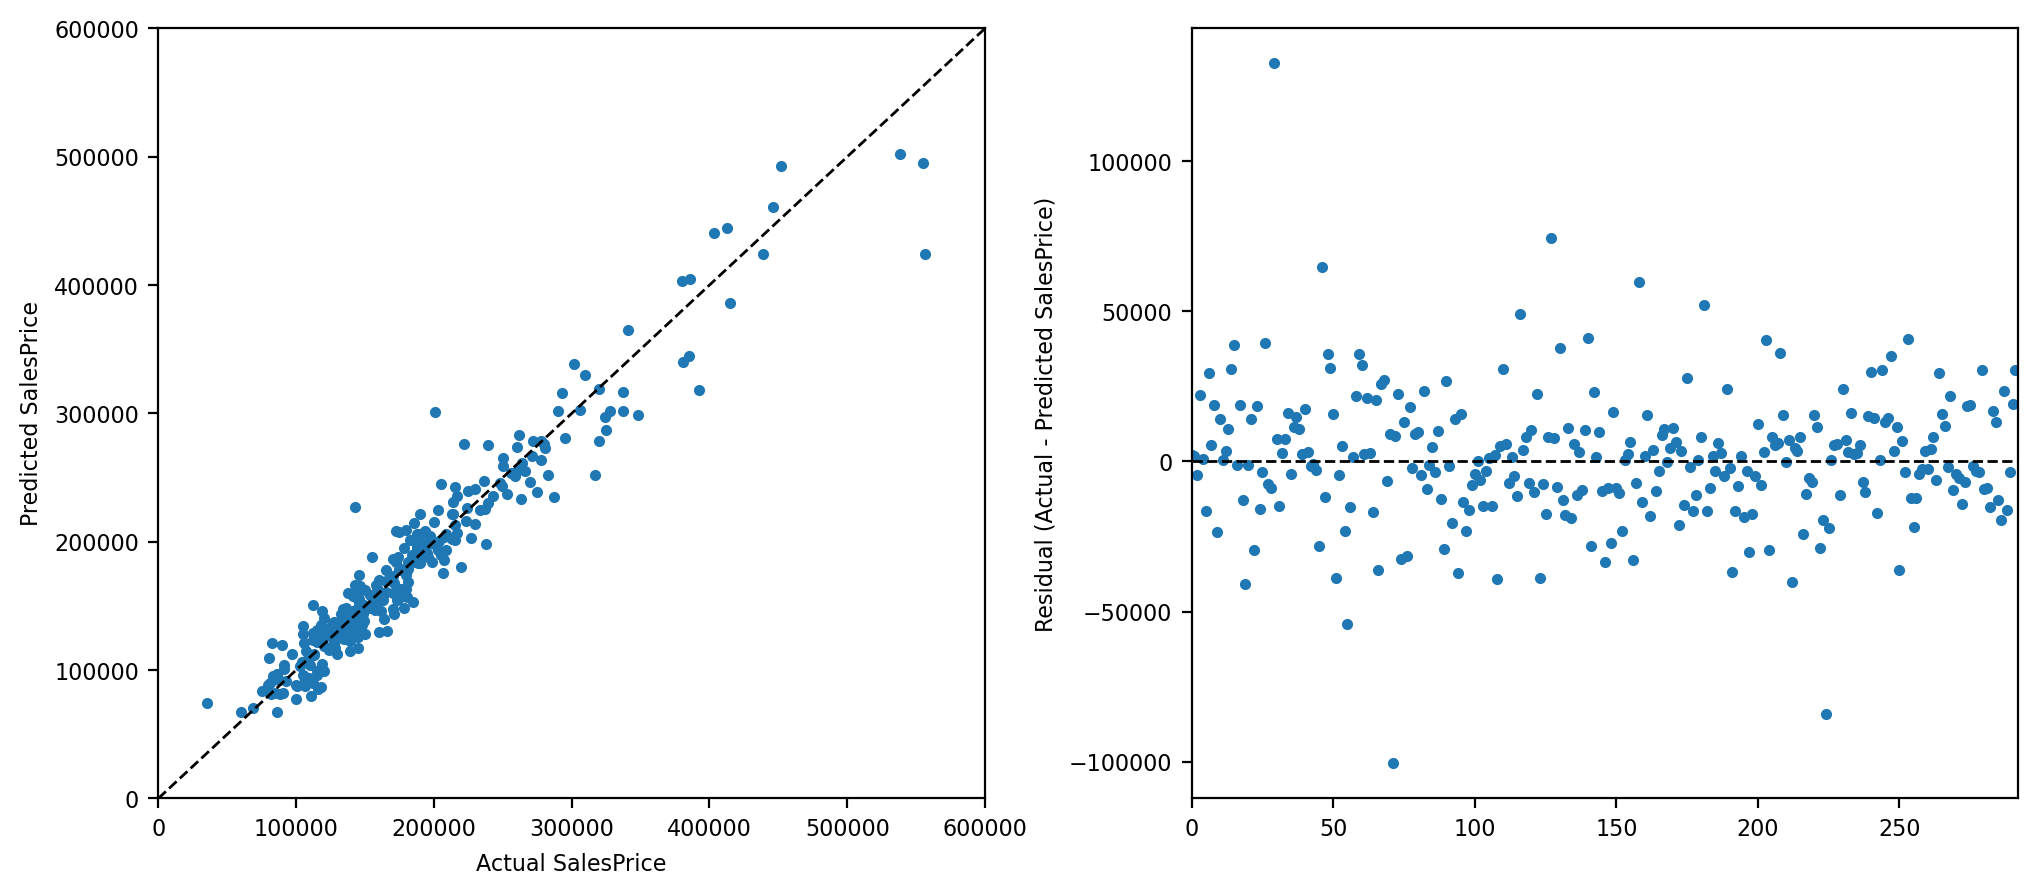

In [445]:
fig, axs = subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.25}, figsize=(12, 5))

axs[0].plot(y_te.values, prediction, '.')
axs[0].plot([0, 600000], [0, 600000], 'k--', lw=1)
axs[0].set_ylabel('Predicted SalesPrice')
axs[0].set_xlabel('Actual SalesPrice')
axs[0].set_ylim(0, 600000)
axs[0].set_xlim(0, 600000)

axs[1].plot(y_te.values - prediction, '.')
axs[1].plot([0, len(y_te)], [0, 0], 'k--', lw=1)
axs[1].set_ylabel('Residual (Actual - Predicted SalesPrice)')
axs[1].set_xlim(0, len(y_te));